# Predict with pre-trained models

This tutorial explains how to recognize objects in an image with a
pre-trained model, and how to perform feature extraction.

## Prerequisites

To complete this tutorial, we need:

- MXNet. See the instructions for your operating system in [Setup and Installation](http://mxnet.io/get_started/install.html)

- [Python Requests](http://docs.python-requests.org/en/master/), [Matplotlib](https://matplotlib.org/) and [Jupyter Notebook](http://jupyter.org/index.html).

```
$ pip install requests matplotlib jupyter
```

## Loading

We first download a pre-trained ResNet 152 layer that is trained on the full
ImageNet dataset with over 10 million images and 10 thousand classes. A
pre-trained model contains two parts, a json file containing the model
definition and a binary file containing the parameters. In addition, there may be
a text file for the labels.

In [1]:
import mxnet as mx
path='http://data.mxnet.io/models/imagenet-11k/'
[mx.test_utils.download(path+'resnet-152/resnet-152-symbol.json'),
 mx.test_utils.download(path+'resnet-152/resnet-152-0000.params'),
 mx.test_utils.download(path+'synset.txt')]

['resnet-152-symbol.json', 'resnet-152-0000.params', 'synset.txt']

Next, we load the downloaded model. *Note:* If GPU is available, we can replace all
occurrences of `mx.cpu()` with `mx.gpu()` to accelerate the computation.

In [2]:
sym, arg_params, aux_params = mx.model.load_checkpoint('resnet-152', 0)
mod = mx.mod.Module(symbol=sym, context=mx.cpu(), label_names=None)
mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))], 
         label_shapes=mod._label_shapes)
mod.set_params(arg_params, aux_params, allow_missing=True)
with open('synset.txt', 'r') as f:
    labels = [l.rstrip() for l in f]

## Predicting

We first define helper functions for downloading an image and performing the
prediction:

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
# define a simple data batch
from collections import namedtuple
Batch = namedtuple('Batch', ['data'])

def get_image(url, show=False):
    # download and show the image
    fname = mx.test_utils.download(url)
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    if img is None:
         return None
    if show:
         plt.imshow(img)
         plt.axis('off')
    # convert into format (batch, RGB, width, height)
    img = cv2.resize(img, (224, 224))
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2)
    img = img[np.newaxis, :]
    return img

def predict(url):
    img = get_image(url, show=True)
    # compute the predict probabilities
    mod.forward(Batch([mx.nd.array(img)]))
    prob = mod.get_outputs()[0].asnumpy()
    # print the top-5
    prob = np.squeeze(prob)
    a = np.argsort(prob)[::-1]
    for i in a[0:5]:
        print('probability=%f, class=%s' %(prob[i], labels[i]))

Now, we can perform prediction with any downloadable URL:

probability=0.695975, class=n02122948 kitten, kitty
probability=0.042497, class=n01323155 kit
probability=0.030121, class=n01318894 pet
probability=0.029758, class=n02122878 tabby, queen
probability=0.026040, class=n01322221 baby


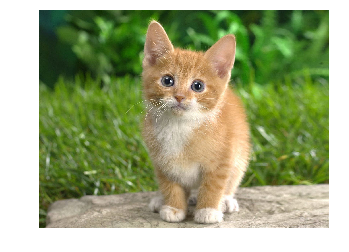

In [4]:
predict('http://writm.com/wp-content/uploads/2016/08/Cat-hd-wallpapers.jpg')

probability=0.443745, class=n02110958 pug, pug-dog
probability=0.101610, class=n13905792 wrinkle, furrow, crease, crinkle, seam, line
probability=0.024097, class=n01318894 pet
probability=0.023298, class=n02083346 canine, canid
probability=0.023097, class=n02084732 pooch, doggie, doggy, barker, bow-wow


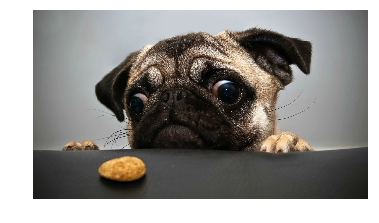

In [5]:
predict('http://thenotoriouspug.com/wp-content/uploads/2015/01/Pug-Cookie-1920x1080-1024x576.jpg')

## Feature extraction

By feature extraction, we mean presenting the input images by the output of an
internal layer rather than the last softmax layer. These outputs, which can be
viewed as the feature of the raw input image, can then be used by other
applications such as object detection.

We can use the ``get_internals`` method to get all internal layers from a
Symbol.

In [6]:
# list the last 10 layers
all_layers = sym.get_internals()
all_layers.list_outputs()[-10:]

['bn1_moving_var',
 'bn1_output',
 'relu1_output',
 'pool1_output',
 'flatten0_output',
 'fc1_weight',
 'fc1_bias',
 'fc1_output',
 'softmax_label',
 'softmax_output']

An often used layer for feature extraction is the one before the last fully
connected layer. For ResNet, and also Inception, it is the flattened layer with
name `flatten0` which reshapes the 4-D convolutional layer output into 2-D for
the fully connected layer. The following source code extracts a new Symbol which
outputs the flattened layer and creates a model.

In [7]:
fe_sym = all_layers['flatten0_output']
fe_mod = mx.mod.Module(symbol=fe_sym, context=mx.cpu(), label_names=None)
fe_mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))])
fe_mod.set_params(arg_params, aux_params)

We can now invoke `forward` to obtain the features:

In [8]:
img = get_image('http://writm.com/wp-content/uploads/2016/08/Cat-hd-wallpapers.jpg')
fe_mod.forward(Batch([mx.nd.array(img)]))
features = fe_mod.get_outputs()[0].asnumpy()
print(features)
assert features.shape == (1, 2048)

[[ 0.43376932  1.01670492  0.13611652 ...,  1.48048818  0.14093973
   0.65973562]]



<!-- INSERT SOURCE DOWNLOAD BUTTONS -->

